# 🤖  Mini-Transformer with NumPy: A Hands-On Tutorial

Author: Ioana Ciucă 

## Learning Objectives

By completing this tutorial, you will:
- Understand how to build a transformer step-by-step: tokenization -> embedding -> transformer block -> output logits.
- Implement a transformer with a single attention layer and no MLP layer  
- Visualize how attention works

Through this tutorial, you will implement the folllowing:
#### 1. **Tokenizer** 
Transform text into numbers that the model can process

#### 2. **Embeddings**
- Token embeddings: Learn representations for each token
- If we have time: Sinusoidal positional encoding, which tell the model about word order

#### 3. **Single-Head Causal Self-Attention** 
The heart of the transformer:
- **Query ($W_Q$)**, **Key ($W_K$)**, **Value ($W_V$)** projections
- Attention scores with causal masking
- Softmax normalization
- Simple residual connections

#### 4. **Output Layer** 
Linear transformation to predict the next token


## Imports & helpers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# 1. The Tokenizer 

Before a neural network can understand text, we need to convert words into numbers. This process, called **tokenization**, is the foundation of every language model, from BERT to GPT.

## How Our Simple Tokenizer Works

### 1. **Splitting Text into Tokens** 
We separate words and punctuation, treating each as its own unit:
- `"Hello, world!"` → `["hello", ",", "world", "!"]`
- Everything gets converted to lowercase for consistency
- Punctuation becomes separate tokens (important for understanding sentence structure!)

### 2. **Building a Vocabulary**
We scan all training texts and create a mapping:
```python
token_to_id = {
    "!": 0,
    ",": 1,
    ".":2,
    "hello": 3,
    "peace": 4,
    "world": 5,
    ...
}
```
Each unique token gets its own ID. The vocabulary only includes tokens seen during training.

### 3. **Encoding: Text → Numbers**
Convert any text into a sequence of IDs:
- `"Hello world!"` → `[3, 5, 0]`
- Unknown tokens (not in vocabulary) are skipped with a warning
- Example: `"Hello, world!"` → `[3, 1, 5, 0]` (comma is skipped if not in vocab)

### 4. **Decoding: Numbers → Text**
Reverse the process to see what the model "sees":
- `[3, 5, 0]` → `"hello world!"`
- Punctuation spacing is cleaned up for readability

## Key Points
- **No special tokens** for simplicity (no `<pad>`, `<bos>`, `<eos>`, `<unk>`)
- **Case-insensitive**: "Hello" and "hello" are the same token
- **Vocabulary-dependent**: Can only encode tokens seen during training

## Example Code

```python
# Build vocabulary from training texts
texts = ["Hello world!", "Hello there.", "World peace."]
token_to_id, id_to_token = build_vocab(texts)

# Encode a sentence
sentence = "Hello world!"
token_ids = encode(sentence, token_to_id)
# Result: [3, 5, 0]

# Decode back to text
decoded = decode(token_ids, id_to_token)
# Result: "hello world!"
```

## Why This Matters

1. **Foundation for embeddings**: Each token ID will map to an embedding vector
2. **Consistent representation**: Same word always gets same ID
3. **Handles punctuation**: Periods, commas, etc. are important for meaning
4. **Simple to understand**: No complex subword tokenization (like Byte-Pair Encoding or WordPiece)

In [3]:
def tokenize(text):
    """Split text into tokens, handling punctuation"""
    # Convert to lowercase
    text = text.lower()

    # Add spaces around punctuation
    punct = '.,!?;:"()[]{}'
    for p in punct:
        text = text.replace(p, f' {p} ')

    # Split on spaces and remove empty strings
    tokens = text.split()
    return tokens

def build_vocab(texts):
    """Build vocabulary from list of texts"""
    vocab = set()
    for text in texts:
        tokens = tokenize(text)
        vocab.update(tokens)

    # Sort for consistent ordering
    sorted_vocab = sorted(list(vocab))

    # Create mappings
    token_to_id = {token: i for i, token in enumerate(sorted_vocab)}
    id_to_token = {i: token for i, token in enumerate(sorted_vocab)}

    return token_to_id, id_to_token

def encode(text, token_to_id):
    """Convert text to list of token IDs"""
    tokens = tokenize(text)
    ids = []
    unknown_tokens = []

    for token in tokens:
        if token in token_to_id:
            ids.append(token_to_id[token])
        else:
            # For teaching purposes, let's track what's unknown
            unknown_tokens.append(token)
            # You could add: ids.append(token_to_id.get('<unk>', 0))

    if unknown_tokens:
        print(f"  Warning: Unknown tokens skipped: {unknown_tokens}")

    return np.array(ids, dtype=np.int32)

def decode(ids, id_to_token):
    """Convert list of token IDs back to text"""
    tokens = [id_to_token[id] for id in ids]

    # Join tokens with spaces
    text = " ".join(tokens)

    # Clean up spacing around punctuation for readability
    punct = '.,!?;:"()[]{}'
    for p in punct:
        text = text.replace(f' {p}', p)

    return text

### Try it out :)

In [4]:
# Example usage
texts = ["Hello, world!", "Hello there.", "World peace.", "The cat sat on the mat."]

# Build vocabulary
token_to_id, id_to_token = build_vocab(texts)
print(f"Vocabulary size: {len(token_to_id)}")
print(f"First 10 tokens: {list(token_to_id.items())[:10]}")

# Encode a sentence
sentence = "Hello, world!"
ids = encode(sentence, token_to_id)
print(f"\nOriginal: {sentence}")
print(f"Token IDs: {ids}")

# Decode back
decoded = decode(ids, id_to_token)
print(f"Decoded: {decoded}")

Vocabulary size: 12
First 10 tokens: [('!', 0), (',', 1), ('.', 2), ('cat', 3), ('hello', 4), ('mat', 5), ('on', 6), ('peace', 7), ('sat', 8), ('the', 9)]

Original: Hello, world!
Token IDs: [ 4  1 11  0]
Decoded: hello, world!


## We can build and understand a tiny astronomy-flavored text corpus.

In [5]:
texts = [
    "O B A F G K M O B A F G K M O B A F G K M .",
    "Mercury Venus Earth Mars Jupiter Saturn Uranus Neptune .",
    "The Sun is a G type star in the Milky Way .",
    "Betelgeuse is an M type star .",
    "Rigel is a B type star .",
    "Sirius is an A type star .",
    "Andromeda is also called M31 ."
]

token_to_id, id_to_token =  build_vocab(texts) #TODO: add your code here
vocab_size = len(token_to_id)

print("Vocab size:", vocab_size)
print(f"First 20 tokens: {list(token_to_id.items())[:20]}")

Vocab size: 32
First 20 tokens: [('.', 0), ('a', 1), ('also', 2), ('an', 3), ('andromeda', 4), ('b', 5), ('betelgeuse', 6), ('called', 7), ('earth', 8), ('f', 9), ('g', 10), ('in', 11), ('is', 12), ('jupiter', 13), ('k', 14), ('m', 15), ('m31', 16), ('mars', 17), ('mercury', 18), ('milky', 19)]


In [6]:
# Install: pip install tiktoken
import tiktoken

def demo_real_tokenization():
    """Show how GPT actually tokenizes text"""

    # Get GPT-2's tokenizer
    enc = tiktoken.get_encoding("gpt2")

    # Example text
    text = "The Sun is a G type star in the Milky Way."

    # Tokenize
    tokens = enc.encode(text)

    print("Original text:", text)
    print(f"Token IDs: {tokens}")
    print(f"Number of tokens: {len(tokens)}")

    # Show each token
    print("\nToken breakdown:")
    for token_id in tokens:
        token_str = enc.decode([token_id])
        print(f"  {token_id:5d} → '{token_str}'")

    # Compare with character tokenization
    char_tokens = list(text)
    print(f"\nCharacter tokenization would use {len(char_tokens)} tokens")
    print(f"GPT-2 tokenization uses {len(tokens)} tokens")
    print(f"Efficiency gain: {len(char_tokens)/len(tokens):.1f}x")

    # Show subword tokenization
    interesting_words = [
        "unbelievable",
        "artificial",
        "consciousness",
        "Mars",
        "M31"
    ]

    print("How GPT-2 splits words:")
    for word in interesting_words:
        tokens = enc.encode(word)
        pieces = [enc.decode([t]) for t in tokens]
        print(f"  '{word}' → {pieces}")

# Run the demo
demo_real_tokenization()

Original text: The Sun is a G type star in the Milky Way.
Token IDs: [464, 3825, 318, 257, 402, 2099, 3491, 287, 262, 34822, 6378, 13]
Number of tokens: 12

Token breakdown:
    464 → 'The'
   3825 → ' Sun'
    318 → ' is'
    257 → ' a'
    402 → ' G'
   2099 → ' type'
   3491 → ' star'
    287 → ' in'
    262 → ' the'
  34822 → ' Milky'
   6378 → ' Way'
     13 → '.'

Character tokenization would use 42 tokens
GPT-2 tokenization uses 12 tokens
Efficiency gain: 3.5x
How GPT-2 splits words:
  'unbelievable' → ['un', 'bel', 'iev', 'able']
  'artificial' → ['art', 'ificial']
  'consciousness' → ['conscious', 'ness']
  'Mars' → ['Mars']
  'M31' → ['M', '31']


In [7]:
print("Our Simple Tokenizer:")
print(f"Vocabulary size: {vocab_size}")
print(f"Tokens for 'The Sun': {encode('The Sun', token_to_id)}")

print("How GPT-2 Would Tokenize:")
enc = tiktoken.get_encoding("gpt2")
print(f"Vocabulary size: {enc.n_vocab}")  # 50,257!
print(f"Tokens for 'The Sun': {enc.encode('The Sun')}")

Our Simple Tokenizer:
Vocabulary size: 32
Tokens for 'The Sun': [27 26]
How GPT-2 Would Tokenize:
Vocabulary size: 50257
Tokens for 'The Sun': [464, 3825]


## Q1: Exploring Your Tokenizer

You've built a tokenizer using this astronomy corpus:

```python
texts = [
    "O B A F G K M O B A F G K M O B A F G K M .",
    "Mercury Venus Earth Mars Jupiter Saturn Uranus Neptune .",
    "The Sun is a G type star in the Milky Way .",
    "Betelgeuse is an M type star .",
    "Rigel is a B type star .",
    "Sirius is an A type star .",
    "Andromeda is also called M31 ."
]
```

1. **Without running code**, predict which regular word will have the lowest ID? Why?

2. **Encode patterns**: Encode these test sentences and determine if the first two sentences produce the same results. What would we need for them to produce different results?

```python
test_sentences = [
    "The Sun .",
    "the sun .",
    "Betelgeuse is a star .",
    "Proxima Centauri is a star .",
    "A B C D E F G ."
]
```

In [ ]:
# TODO: add your code here

## 2. Embeddings + (Extra) Sinusoidal Position Encoding

Remember our tokens `[5, 87, 42]`? These numbers don't mean anything to a neural network yet. We need to convert each token into a **vector**, a list of decimal numbers that can capture meaning.

Think of it like this:
- Token ID `5` (maybe "cat") → `[0.2, -0.1, 0.8, ...]` 
- Token ID `87` (maybe "dog") → `[0.3, -0.2, 0.7, ...]`

These vectors can learn that "cat" and "dog" are similar (both animals) by having similar values!

## The Problem with Order

Transformers process all tokens at once (unlike RNNs that go step-by-step). But word order matters!
- "The cat ate the mouse" ≠ "The mouse ate the cat" 🐱🐭

**Solution:** Add position information to each embedding using **sinusoidal positional encoding**.

### The Math

For each position `pos` and dimension `i` in the embedding:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- `pos` = position in the sequence (0, 1, 2, ...)
- `i` = dimension index (0, 1, 2, ..., d_model/2)
- `d_model` = embedding dimension (e.g., 48)

**In simple terms:**
- Even dimensions use `sin`, odd dimensions use `cos`
- Each dimension oscillates at a different frequency
- Lower dimensions change quickly, higher dimensions change slowly
- This creates a unique "fingerprint" for each position!

**Final embedding** = Token embedding + Positional encoding

In [ ]:
def create_embeddings(vocab_size, embedding_dim=4):
    """Create random embeddings for each word"""

    embeddings = np.random.randn(vocab_size, embedding_dim) * 0.5
    return embeddings

def sinusoidal_positional_encoding(T, d_model):
    """Create unique position vectors using sine/cosine waves"""
    pe = np.zeros((T, d_model), dtype=np.float32)

    # For each position in the sequence
    for pos in range(T):
        # For each dimension of the embedding
        for i in range(0, d_model, 2):
            # Calculate the divisor for this dimension
            # This creates different frequencies for different dimensions
            divisor = 10000.0 ** (i / d_model)

            # Apply sine to even dimensions
            pe[pos, i] = np.sin(pos / divisor)

            # Apply cosine to odd dimensions (if not last dimension)
            if i + 1 < d_model:
                pe[pos, i + 1] = np.cos(pos / divisor)

    return pe

def embed(token_ids, W_E, PE=None):
    """
    Get embeddings for tokens, optionally adding positional information

    Args:
        token_ids: List or array of token IDs
        W_E: Embedding matrix (vocab_size, embedding_dim)
        PE: Positional encoding matrix (max_seq_len, embedding_dim) or None

    Returns:
        Embeddings with or without positional encoding
    """
    embeddings = W_E[token_ids]

    if PE is not None:
        # Add positional encoding if provided
        embeddings = embeddings + PE[:len(token_ids)]

    return embeddings

## Q2: Explore embeddings with a simple corpus of two sentences.

In [15]:
# Build vocabulary
sentences = ["the cat sat on the mat", "The dog sat on the log"]
word_to_id, id_to_token = build_vocab(sentences)

print("VOCABULARY")
print("=" * 60)
for word, word_id in sorted(word_to_id.items()):
    print(f"  '{word}' -> {word_id}")
print(f"\nTotal vocabulary size: {len(word_to_id)}")

# Create embedding matrix (W_E)
vocab_size = len(word_to_id)
W_E = create_embeddings(vocab_size, embedding_dim=4)

print(f"\nEMBEDDING MATRIX (W_E)")
print("=" * 60)
print(f"Shape: {W_E.shape} (vocab_size={vocab_size}, dim=4)")
print(f"This is W_E! Each row is a word's embedding vector.")
print(f"\nFirst 3 embeddings:")
for i in range(min(3, vocab_size)):
    print(f"  Token {i} ('{id_to_token[i]}'):",
          f"[{W_E[i,0]:6.3f}, {W_E[i,1]:6.3f}, {W_E[i,2]:6.3f}, {W_E[i,3]:6.3f}]")

# Create positional encodings
PE = sinusoidal_positional_encoding(T=100, d_model=4)

print(f"\nPOSITIONAL ENCODING (PE)")
print("=" * 60)
print(f"Shape: {PE.shape} (max_seq_len=100, dim=4)")
print(f"First 3 position encodings:")
for pos in range(3):
    print(f"  Position {pos}: [{PE[pos,0]:6.3f}, {PE[pos,1]:6.3f}, {PE[pos,2]:6.3f}, {PE[pos,3]:6.3f}]")

VOCABULARY
  'cat' -> 0
  'dog' -> 1
  'log' -> 2
  'mat' -> 3
  'on' -> 4
  'sat' -> 5
  'the' -> 6

Total vocabulary size: 7

EMBEDDING MATRIX (W_E)
Shape: (7, 4) (vocab_size=7, dim=4)
This is W_E! Each row is a word's embedding vector.

First 3 embeddings:
  Token 0 ('cat'): [ 0.050, -0.252, -0.775,  0.034]
  Token 1 ('dog'): [-0.531,  0.237, -0.460,  0.775]
  Token 2 ('log'): [-0.392, -0.161,  0.407, -0.615]

POSITIONAL ENCODING (PE)
Shape: (100, 4) (max_seq_len=100, dim=4)
First 3 position encodings:
  Position 0: [ 0.000,  1.000,  0.000,  1.000]
  Position 1: [ 0.841,  0.540,  0.010,  1.000]
  Position 2: [ 0.909, -0.416,  0.020,  1.000]


In [16]:
# Convert a sentence to embeddings
sentence = "the cat sat on the mat"
words = tokenize(sentence)
word_ids = [word_to_id[word] for word in words]

print(f"\nPROCESSING SENTENCE: '{sentence}'")
print("=" * 60)
print(f"Words:     {words}")
print(f"Word IDs:  {word_ids}")



PROCESSING SENTENCE: 'the cat sat on the mat'
Words:     ['the', 'cat', 'sat', 'on', 'the', 'mat']
Word IDs:  [6, 0, 5, 4, 6, 3]


In [17]:
#  Using embed() WITHOUT positional encoding
print(f"\nMETHOD 2: USING embed() WITHOUT POSITIONAL ENCODING")
print("-" * 40)
embeddings_no_pe = embed(word_ids, W_E)
print(f"embeddings = embed(word_ids, W_E)")
print(f"Shape: {embeddings_no_pe.shape}")

#  Using embed() WITH positional encoding
print(f"\nMETHOD 3: USING embed() WITH POSITIONAL ENCODING")
print("-" * 40)
embeddings_with_pe = embed(word_ids, W_E, PE)
print(f"embeddings = embed(word_ids, W_E, PE)")
print(f"Shape: {embeddings_with_pe.shape}")


METHOD 2: USING embed() WITHOUT POSITIONAL ENCODING
----------------------------------------
embeddings = embed(word_ids, W_E)
Shape: (6, 4)

METHOD 3: USING embed() WITH POSITIONAL ENCODING
----------------------------------------
embeddings = embed(word_ids, W_E, PE)
Shape: (6, 4)


### Q2.1 Compare the embeddings of the token "the" at positions 0 and 4. Are they the same when using positional encoding? What about without positional encoding?



In [31]:
# TODO: Your code here

## For more info, you can have a more in depth read here.

https://alessiodevoto.github.io/LLM-Embedding-Space/

Let us pretend we have trained our model and that we have a tokenizer that treats "The" and "the" as tokens with different embeddings. We obtained the values inside $W_E$ after training.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the words in our sentence
words = ['The', 'cat', 'sat', 'on', 'the', 'mat']

# Create simple embeddings for each word
embeddings = np.array([
    [1.0, 0.0, 0.0, 0.0],  # The
    [0.0, 1.0, 0.0, 0.0],  # cat
    [0.0, 0.0, 0.5, 0.0],  # sat
    [0.0, 0.0, 0.0, 1.0],  # on
    [0.5, 0.5, 0.0, 0.0],  # the (lowercase)
    [0.0, 0.5, 0.5, 0.0],  # mat
])

print("EMBEDDINGS")
print("=" * 50)
for i, word in enumerate(words):
    print(f"{word:3s}: {embeddings[i]}")

print(f"\nEmbedding matrix shape: {embeddings.shape}")
print(f"  -> {embeddings.shape[0]} tokens in the sentence")
print(f"  -> {embeddings.shape[1]} dimensions per embedding")

EMBEDDINGS
The: [1. 0. 0. 0.]
cat: [0. 1. 0. 0.]
sat: [0.  0.  0.5 0. ]
on : [0. 0. 0. 1.]
the: [0.5 0.5 0.  0. ]
mat: [0.  0.5 0.5 0. ]

Embedding matrix shape: (6, 4)
  -> 6 tokens in the sentence
  -> 4 dimensions per embedding


## Understanding W_E vs Sentence Embeddings

### The Confusion

When we see this code:
```python
embeddings = np.array([
    [1.0, 0.0, 0.0, 0.0],  # The
    [0.0, 1.0, 0.0, 0.0],  # cat
    [0.0, 0.0, 0.5, 0.0],  # sat
    [0.0, 0.0, 0.0, 1.0],  # on
    [0.5, 0.5, 0.0, 0.0],  # the
    [0.0, 0.5, 0.5, 0.0],  # mat
])
```

**This is NOT W_E!** This is already the result of looking up words in W_E.

### What's the Difference?

#### W_E (Embedding Matrix)
- **What it is**: The full vocabulary embedding matrix
- **Shape**: `(vocab_size, embedding_dim)`
- **Contains**: Embeddings for ALL words in vocabulary
- **Example**: If vocab has 1000 words, W_E is `(1000, 4)`

#### Sentence Embeddings
- **What it is**: Embeddings for words in a specific sentence
- **Shape**: `(sentence_length, embedding_dim)`
- **Contains**: Only embeddings for words in this sentence
- **Example**: For 6-word sentence, embeddings is `(6, 4)`


## 3. The Attention Mechanism

W_q: Transforms input → "What am I looking for?"

W_k: Transforms input → "What do I have to offer?"

## The QK Circuit
```
Q = Input @ W_q.T
K = Input @ W_k.T
Attention = Q @ K^T/sqrt(d_K)
```

High score = words should attend to each other

In [61]:
# These are hand-crafted to show how 'cat' and 'mat' can find each other
# This is W_q, the query projection matrix
# first column is the query projection for 'The', second for 'cat', etc.
W_q = np.array([[0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
                [0.0, 1.0, 0.5, 0.0, 0.0, 1.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])

# Define weight matrices for keys
# first column is the key projection for 'The', second for 'cat', etc.
W_k = np.array([[0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
                [0.0, 1.0, 0.5, 0.0, 0.0, 1.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])


print("\nWEIGHT MATRICES")
print("=" * 50)
print("W_k shape:", W_k.shape)
print("W_q shape:", W_q.shape)

# Form the input sequence (our sentence)
input_sequence = embeddings  # All 6 words in order

# Calculate keys and queries
# Note: W_k and W_q are already per-word, so we multiply element-wise
keys = input_sequence @ W_k
queries = input_sequence @ W_q

print("\nKEYS AND QUERIES")
print("=" * 50)
print("Keys shape:", keys.shape)
print("Queries shape:", queries.shape)

# Look at the attributes of "cat" (index 1)
cat_idx = 1
print(f"\nKeys for 'cat':")
print(keys[cat_idx])
print(f"  Non-zero at positions: {np.where(keys[cat_idx] != 0)[0].tolist()}")

# Look at what "mat" is looking for (index 5)
mat_idx = 5
print(f"\nQueries for 'mat':")
print(queries[mat_idx])
print(f"  Non-zero at positions: {np.where(queries[mat_idx] != 0)[0].tolist()}")


WEIGHT MATRICES
W_k shape: (4, 6)
W_q shape: (4, 6)

KEYS AND QUERIES
Keys shape: (6, 6)
Queries shape: (6, 6)

Keys for 'cat':
[0. 1. 0. 0. 0. 1.]
  Non-zero at positions: [1, 5]

Queries for 'mat':
[0.   1.   0.25 0.   0.   1.  ]
  Non-zero at positions: [1, 2, 5]



Match score between 'cat' key and 'mat' query: 2.0
Match score between 'mat' key and 'cat' query: 2.0

These high scores show that 'cat' and 'mat' are designed to find each other!

ATTENTION SCORES
Attention scores matrix:
[[0.51031036 0.         0.         0.         0.25515518 0.        ]
 [0.         0.81649658 0.40824829 0.         0.40824829 0.81649658]
 [0.         0.40824829 0.22963966 0.         0.20412415 0.43376381]
 [0.         0.         0.         0.40824829 0.         0.        ]
 [0.25515518 0.40824829 0.20412415 0.         0.33170174 0.40824829]
 [0.         0.81649658 0.43376381 0.         0.40824829 0.8420121 ]]

Attention scores table:
        The    cat    sat    on     the    mat    
The   :   0.51   0.00   0.00   0.00   0.26   0.00 
cat   :   0.00   0.82   0.41   0.00   0.41   0.82 
sat   :   0.00   0.41   0.23   0.00   0.20   0.43 
on    :   0.00   0.00   0.00   0.41   0.00   0.00 
the   :   0.26   0.41   0.20   0.00   0.33   0.41 
mat   :   0.00   0.82   0.43  

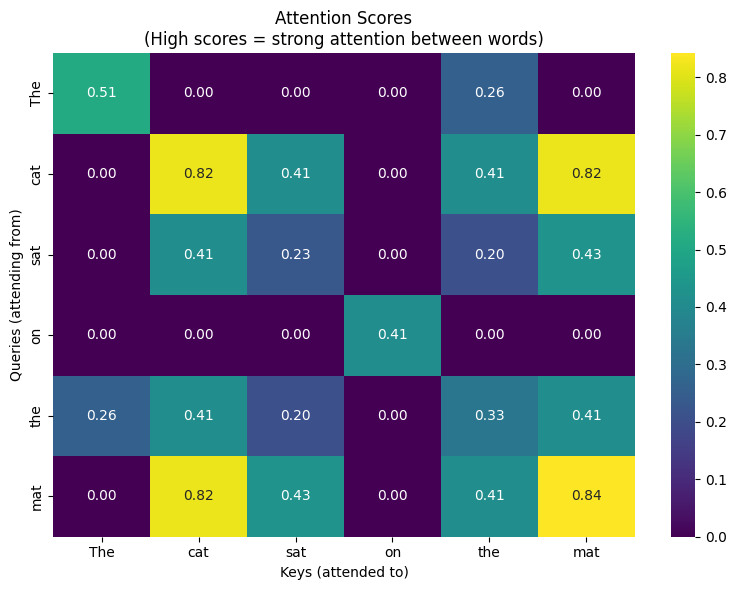


STRONG CONNECTIONS (score ≥ 1.0)


In [62]:
# Compute the match score between cat's key and mat's query
match_key_query = keys[cat_idx] @ queries[mat_idx]
print(f"\nMatch score between 'cat' key and 'mat' query: {match_key_query}")

# Check the reverse - mat's key and cat's query
match_query_key = keys[mat_idx] @ queries[cat_idx]
print(f"Match score between 'mat' key and 'cat' query: {match_query_key}")

print("\nThese high scores show that 'cat' and 'mat' are designed to find each other!")

# Calculate attention scores for all pairs
print("\n" + "=" * 50)
print("ATTENTION SCORES")
print("=" * 50)

d_k = keys.shape[1]
attention_scores = queries @ keys.T / np.sqrt(d_k) # Why do we divide by sqrt(d_k)?

print("Attention scores matrix:")
print(attention_scores)

# Create a more readable view
print("\nAttention scores table:")
print("        ", end="")
for word in words:
    print(f"{word:6s}", end=" ")
print()

for i, word in enumerate(words):
    print(f"{word:6s}:", end=" ")
    for j in range(len(words)):
        print(f"{attention_scores[i,j]:6.2f}", end=" ")
    print()

# Highlight the cat-mat connection
print(f"\nNotice: 'cat' → 'mat' score = {attention_scores[cat_idx, mat_idx]:.1f}")
print(f"        'mat' → 'cat' score = {attention_scores[mat_idx, cat_idx]:.1f}")
print("These are the highest scores, showing they 'find' each other!")

# Visualize the attention scores
plt.figure(figsize=(8, 6))
sns.heatmap(attention_scores, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=words, yticklabels=words)
plt.title("Attention Scores\n(High scores = strong attention between words)")
plt.xlabel("Keys (attended to)")
plt.ylabel("Queries (attending from)")
plt.tight_layout()
plt.show()

# Show which word pairs have strong attention
print("\n" + "=" * 50)
print("STRONG CONNECTIONS (score ≥ 1.0)")
print("=" * 50)
for i, word_i in enumerate(words):
    for j, word_j in enumerate(words):
        if attention_scores[i, j] >= 1.0:
            print(f"'{word_i}' attends to '{word_j}': {attention_scores[i, j]:.2f}")

## When training GPT to predict the next word, it can't look ahead at future words - that's cheating!

Triangular masking blocks each word from seeing words that come after it, forcing the model to predict based only on previous context.

In [64]:
print("\n" + "=" * 50)
print("TRIANGULAR MASKING")
print("=" * 50)

# Create mask with -inf for upper triangle (future positions)
mask = np.triu(np.ones_like(attention_scores) * -np.inf, k=1)
masked_attention_scores = attention_scores + mask

print("Mask (0 = keep, -inf = mask out):")
print(mask)

print("\nMasked attention scores:")
print(masked_attention_scores)


TRIANGULAR MASKING
Mask (0 = keep, -inf = mask out):
[[  0. -inf -inf -inf -inf -inf]
 [  0.   0. -inf -inf -inf -inf]
 [  0.   0.   0. -inf -inf -inf]
 [  0.   0.   0.   0. -inf -inf]
 [  0.   0.   0.   0.   0. -inf]
 [  0.   0.   0.   0.   0.   0.]]

Masked attention scores:
[[0.51031036       -inf       -inf       -inf       -inf       -inf]
 [0.         0.81649658       -inf       -inf       -inf       -inf]
 [0.         0.40824829 0.22963966       -inf       -inf       -inf]
 [0.         0.         0.         0.40824829       -inf       -inf]
 [0.25515518 0.40824829 0.20412415 0.         0.33170174       -inf]
 [0.         0.81649658 0.43376381 0.         0.40824829 0.8420121 ]]


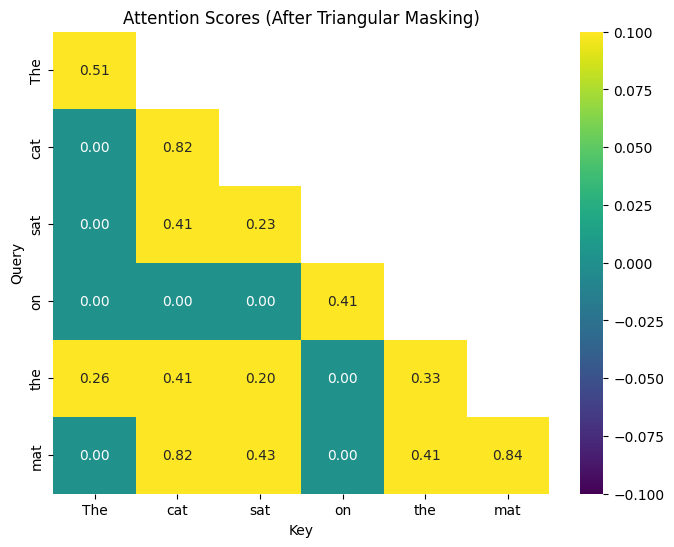

In [65]:
# Visualize masked attention scores
plt.figure(figsize=(8, 6))
sns.heatmap(masked_attention_scores, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=words, yticklabels=words)
plt.title("Attention Scores (After Triangular Masking)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

## After masking, we apply softmax to convert the scores into probabilities that sum to 1, giving us a proper probability distribution over previous words.

## A quick dive into softmax

Softmax converts a list of numbers (scores) into probabilities that sum to 1.

**Input:** Any list of numbers, like `[2, 5, 1]`  
**Output:** Probabilities that sum to 1, like `[0.04, 0.87, 0.09]`

For each score $z_i$ in your list:

$$\text{probability}_i = \frac{e^{z_i}}{\text{sum of all } e^z}$$

#### Example
Given scores `[2, 5, 1]`:
- Calculate: $e^2 \approx 7.4$, $e^5 \approx 146.1 $, $e^1 \approx 2.7$
- Sum: $7.4 + 146.1 + 2.7 = 156.2$
- Probabilities: $[7.4/156.2, 146.4/156.2, 2.7/156.2] = [0.05, 0.94, 0.02]$

The highest score (5) gets the highest probability (94%).

#### Why Use Softmax?

1. **Creates valid probabilities**: All outputs between 0 and 1, sum to 1
2. **Preserves order**: Higher scores → higher probabilities
3. **Differentiable**: Works well with neural networks


#### Numerical Stability Trick

**Problem:** $e^{1000}$ causes overflow!

**Solution:** Subtract the maximum score first.

In [ ]:
def stable_softmax(x, axis=-1):
    """
    TODO-1: Implement numerically stable softmax along `axis`.
    Steps:
      1) subtract the row-wise max
      2) exponentiate
      3) divide by row-wise sum
    """
    """Apply softmax along specified axis"""
    # For numerical stability, subtract max
    x_max = np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)


In [29]:
def test_softmax():
    """Simple test case for stable_softmax"""

    # Test input: scores for 3 classes
    x = np.array([2.0, 5.0, 1.0])

    # Run your implementation
    probs = stable_softmax(x)

    # Check if it sums to 1
    assert np.isclose(probs.sum(), 1.0), f"Probabilities don't sum to 1: {probs.sum()}"

    # Check expected values (approximately)
    expected = np.array([0.0466, 0.9362, 0.0172])
    assert np.allclose(probs, expected, atol=0.01), f"Got {probs}, expected ~{expected}"

    print("✅ Test passed!")
    print(f"Input:  {x}")
    print(f"Output: {probs}")
    print(f"Sum:    {probs.sum()}")

    return x, probs


scores, probs = test_softmax()

✅ Test passed!
Input:  [2. 5. 1.]
Output: [0.04661262 0.93623955 0.01714783]
Sum:    1.0


[2. 5. 1.]


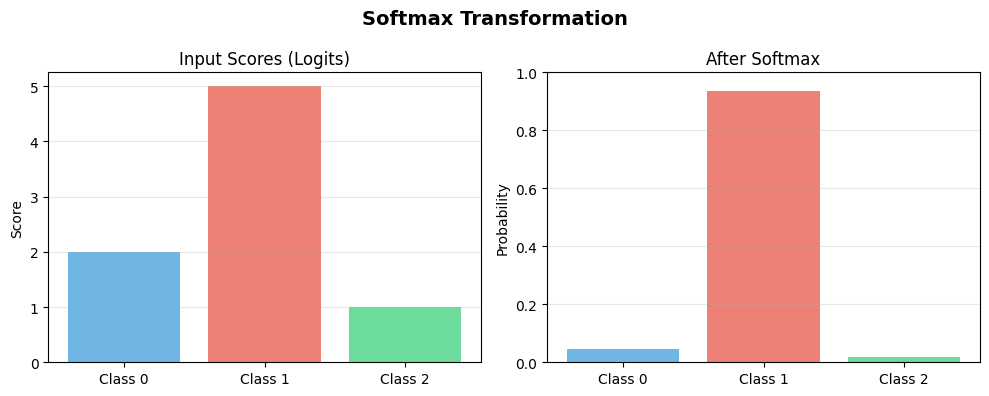


 Try different scores to see how softmax behaves:
Example: test_scores = np.array([1, 1, 1]) for uniform distribution
Example: test_scores = np.array([10, 0, 0]) for very confident prediction


In [30]:
# Visualize how softmax transforms scores to probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Input scores
classes = ['Class 0', 'Class 1', 'Class 2']
colors = ['#3498db', '#e74c3c', '#2ecc71']

print(scores)
scores = scores # you can vary here to see how softmax behaves, for example: np.array([1, 1, 1])

ax1.bar(classes, scores, color=colors, alpha=0.7)
ax1.set_ylabel('Score')
ax1.set_title('Input Scores (Logits)')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Output probabilities
ax2.bar(classes, probs, color=colors, alpha=0.7)
ax2.set_ylabel('Probability')
ax2.set_title('After Softmax')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Softmax Transformation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interactive experiment
print("\n Try different scores to see how softmax behaves:")
print("Example: test_scores = np.array([1, 1, 1]) for uniform distribution")
print("Example: test_scores = np.array([10, 0, 0]) for very confident prediction")

## Let us return to our problem.

In [66]:
softmax_attention_scores = stable_softmax(masked_attention_scores, axis=1)

print("Softmax normalized attention scores:")
print(softmax_attention_scores)
print("\nRow sums (should all be 1.0):")
print(softmax_attention_scores.sum(axis=1))

Softmax normalized attention scores:
[[1.         0.         0.         0.         0.         0.        ]
 [0.30650784 0.69349216 0.         0.         0.         0.        ]
 [0.26579294 0.39980058 0.33440648 0.         0.         0.        ]
 [0.22201597 0.22201597 0.22201597 0.3339521  0.         0.        ]
 [0.20120597 0.23449218 0.19119581 0.15589363 0.2172124  0.        ]
 [0.10383325 0.23492887 0.16022035 0.10383325 0.15618395 0.24100033]]

Row sums (should all be 1.0):
[1. 1. 1. 1. 1. 1.]


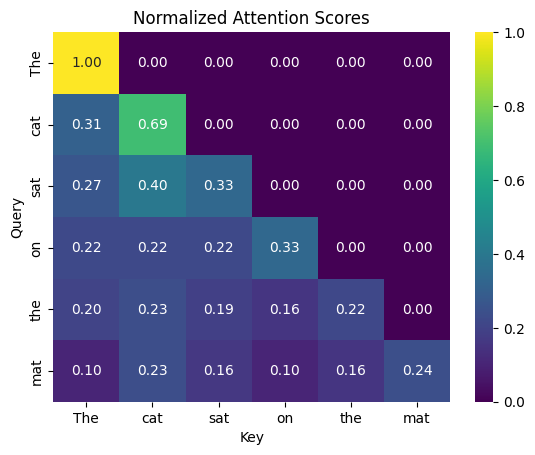

In [67]:
# Visualize the normalized attention scores
sns.heatmap(softmax_attention_scores, annot=True, cmap='viridis', fmt=".2f",   xticklabels=words, yticklabels=words)
plt.title("Normalized Attention Scores")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()

## Now we are ready to mix information across token positions via the OV circuit!

In [84]:
# Define the weight matrix for values.
# Shape = (d_model, d_v)
W_v = np.random.randn(*input_sequence.T.shape)
print("W_v shape:")
print(W_v.shape)

values = input_sequence @ W_v

print("Values shape:")
print(values.shape)

print("Values:")
print(values)

# Apply the normalized attention scores to the values
output = softmax_attention_scores @ values
print("\nATTENTION OUTPUT (before final projection)")
print("=" * 50)
print("Output shape:", output.shape)
print(np.around(output, 6))


W_v shape:
(4, 6)
Values shape:
(6, 6)
Values:
[[-0.82899501 -0.56018104  0.74729361  0.61037027 -0.02090159  0.11732738]
 [ 1.2776649  -0.59157139  0.54709738 -0.20219265 -0.2176812   1.09877685]
 [ 0.41270817  0.40675482  0.6527394   0.01050192  0.34097649 -0.15513338]
 [ 0.32416635 -0.13014305  0.09699596  0.59515703 -0.81822068  2.09238728]
 [ 0.22433494 -0.57587621  0.64719549  0.20408881 -0.1192914   0.60805212]
 [ 1.05154062  0.11096912  0.92628809 -0.09059441  0.23213588  0.39425505]]

ATTENTION OUTPUT (before final projection)
Output shape: (6, 6)
[[-0.828995 -0.560181  0.747294  0.61037  -0.020902  0.117327]
 [ 0.631957 -0.58195   0.608459  0.046864 -0.157367  0.797955]
 [ 0.428482 -0.249381  0.635636  0.084907  0.02144   0.418599]
 [ 0.299496 -0.208863  0.464686  0.291707 -0.250513  0.93431 ]
 [ 0.310976 -0.319037  0.559151  0.214517 -0.143524  0.709867]
 [ 0.602326 -0.208684  0.645094  0.089398 -0.046324  0.652704]]


Text(50.722222222222214, 0.5, 'Tokens')

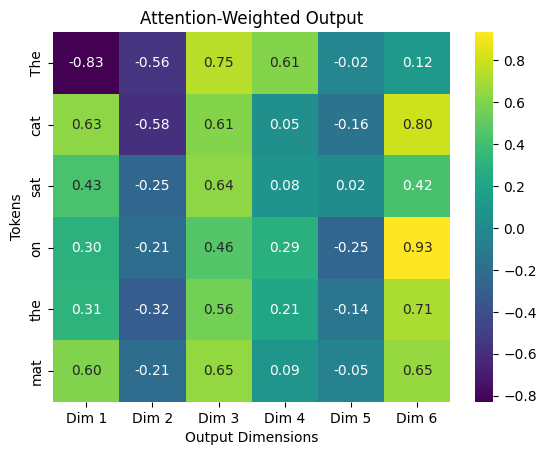

In [101]:
# Heatmap of the attention output (the "OV" circuit)
sns.heatmap(output, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=['Dim 1', 'Dim 2', 'Dim 3', 'Dim 4', 'Dim 5', 'Dim 6'],
            yticklabels=words)
plt.title("Attention-Weighted Output")
plt.xlabel("Output Dimensions")
plt.ylabel("Tokens")


## This new representation is an attention-weighted average of the (value-transformed) words that preceded this word.

In [100]:
# Define the final projection matrix W_o to get back to the residual stream dimension.
# Shape = (d_v, d_model)
W_o = np.array([
    [0.1, 0.0, 0.0, 0.0],
    [0.0, 0.2, 0.0, 0.0],
    [0.0, 0.0, 0.3, 0.0],
    [0.0, 0.0, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0]
])

# Project the attention output back to the original d_model dimension
# This output is then added to the original input (residual connection)
final_output = output @ W_o
print("\nFINAL ATTENTION OUTPUT (after final projection)")
print("=" * 50)
print("Final Output shape:", final_output.shape)
print(np.around(final_output, 6))



FINAL ATTENTION OUTPUT (after final projection)
Final Output shape: (6, 4)
[[-0.0829   -0.112036  0.224188  0.244148]
 [ 0.063196 -0.11639   0.182538  0.018746]
 [ 0.042848 -0.049876  0.190691  0.033963]
 [ 0.02995  -0.041773  0.139406  0.116683]
 [ 0.031098 -0.063807  0.167745  0.085807]
 [ 0.060233 -0.041737  0.193528  0.035759]]


In [88]:
print("Final output shape:")
print(final_output.shape) # notice it's the dimension of the residual stream!

Final output shape:
(6, 4)


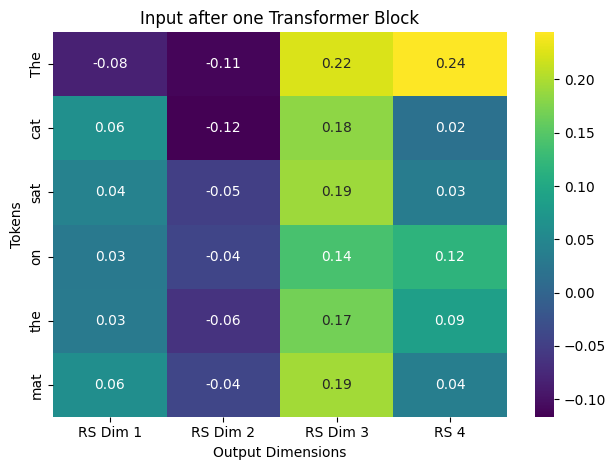

In [96]:
# Heatmap of input after passing through the full attention block
sns.heatmap(final_output, annot=True, cmap='viridis', fmt=".2f",
            xticklabels=['RS Dim 1', 'RS Dim 2', 'RS Dim 3', 'RS 4'],
            yticklabels=words)
plt.title("Input after one Transformer Block")
plt.xlabel("Output Dimensions")
plt.ylabel("Tokens")

plt.tight_layout()
plt.show()


## What happens next?